In [1]:
import subprocess
import os
import sys
import matplotlib.backends.backend_pdf
import scanpy as sc
import matplotlib.pyplot as pl
import anndata as ad
import pandas as pd
import numpy as np
import seaborn as sns
import scvelo as scv
scv.settings.verbosity=1

from pathlib import Path

# Jupyter stuff
from tqdm.notebook import tqdm
from IPython.display import clear_output
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

%matplotlib inline

In [2]:
# Custom functions
sys.path.insert(1, '../..')
from utils import *

# scperturb package
sys.path.insert(1, '../../package/src/')
from scperturb import *

Things to potentially do:
- Run subsampling multiple times to estimate sensitivity
- Run E-tests per sample point to check when we lose significance
- Caputure sigma and delta separately to see what changes how

# Define data

In [109]:
h5_files = {}
spath = '/fast/scratch/users/peidlis_c/perturbation_resource_paper/'
for path, subdirs, files in os.walk(spath):
    for name in files:
        if '.h5' in name: h5_files[name[:-3]] = os.path.join(path, name)
print(len(h5_files))
# list(h5_files.keys())

41


In [110]:
dataset = 'PapalexiSatija2021_eccite_RNA'
control = 'control'
groupby = 'perturbation'

# Dependence on HVGs

In [103]:
def test_HVGs(adata, groupby='perturbation', control='control', num=10, show=True):
    eds = []
    ns = np.linspace(2, adata.n_vars, num=num)
    for n in tqdm(ns):
        sc.pp.highly_variable_genes(adata, n_top_genes=int(n), flavor='seurat_v3', layer='counts')
        sc.pp.pca(adata)
        ed = edist_to_control(adata, groupby, control, verbose=False)
        eds.append(ed)
    df = pd.concat(eds, axis=1).T
    df.index = np.array(ns, dtype=int)
    
    path = Path(f'../snakemake/tables/etest_{dataset}_tables.csv')
    if path.exists():
        et = pd.read_csv(path, index_col=0)
        palette={g: 'tab:blue' if g==control else 'tab:green' if et.loc[g, 'significant_adj'] else 'tab:red' for g in df.columns}
    else:
        palette=None
        
    with sns.axes_style('whitegrid'):
        fig, ax = pl.subplots(1, 1, figsize=(8,6), dpi=100)
    plot=sns.lineplot(data=df.stack().reset_index(), x='level_0', y=0, hue=groupby, ax=ax, marker="o", palette=palette)
    ax.set_ylabel(f'E-distance to {control}')
    ax.set_xlabel('# highly variable genes used for PCA')
    ax.set_title(f'E-distance to {control} vs Number of HVGs for PCA')
    med_df=df.median(1)
    ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

    h,l = plot.axes.get_legend_handles_labels()
    plot.axes.legend_.remove()
    ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

    if show: pl.show()
    return df

100%|██████████| 10/10 [01:29<00:00,  8.91s/it]


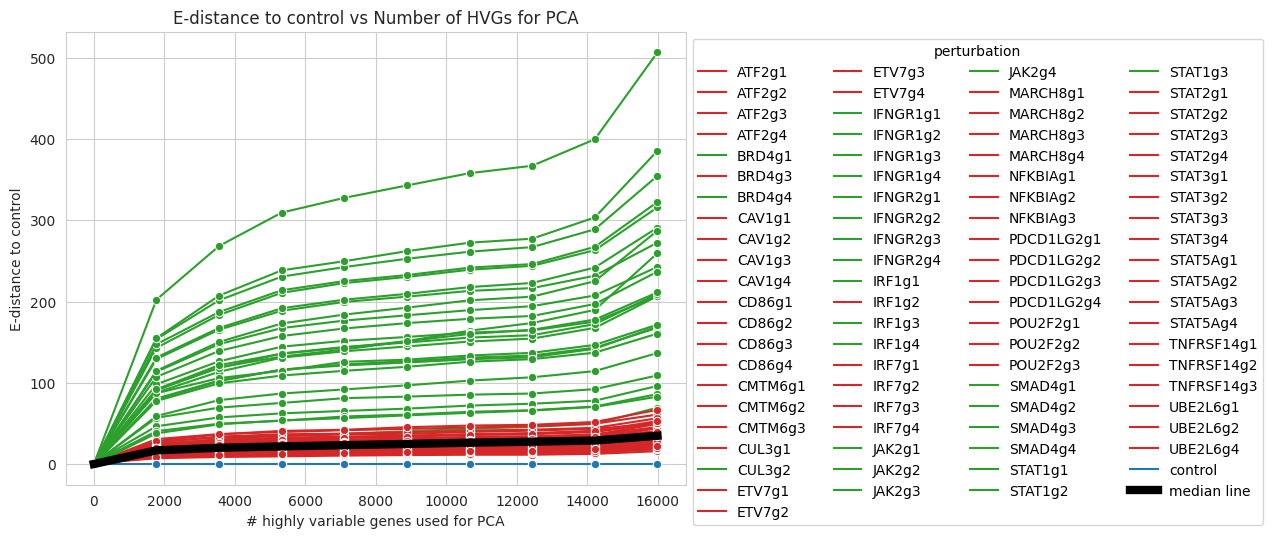

In [104]:
dataset = 'PapalexiSatija2021_eccite_RNA'
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
df = test_HVGs(adata, groupby='perturbation', control='control', num=10)

100%|██████████| 10/10 [04:55<00:00, 29.57s/it]


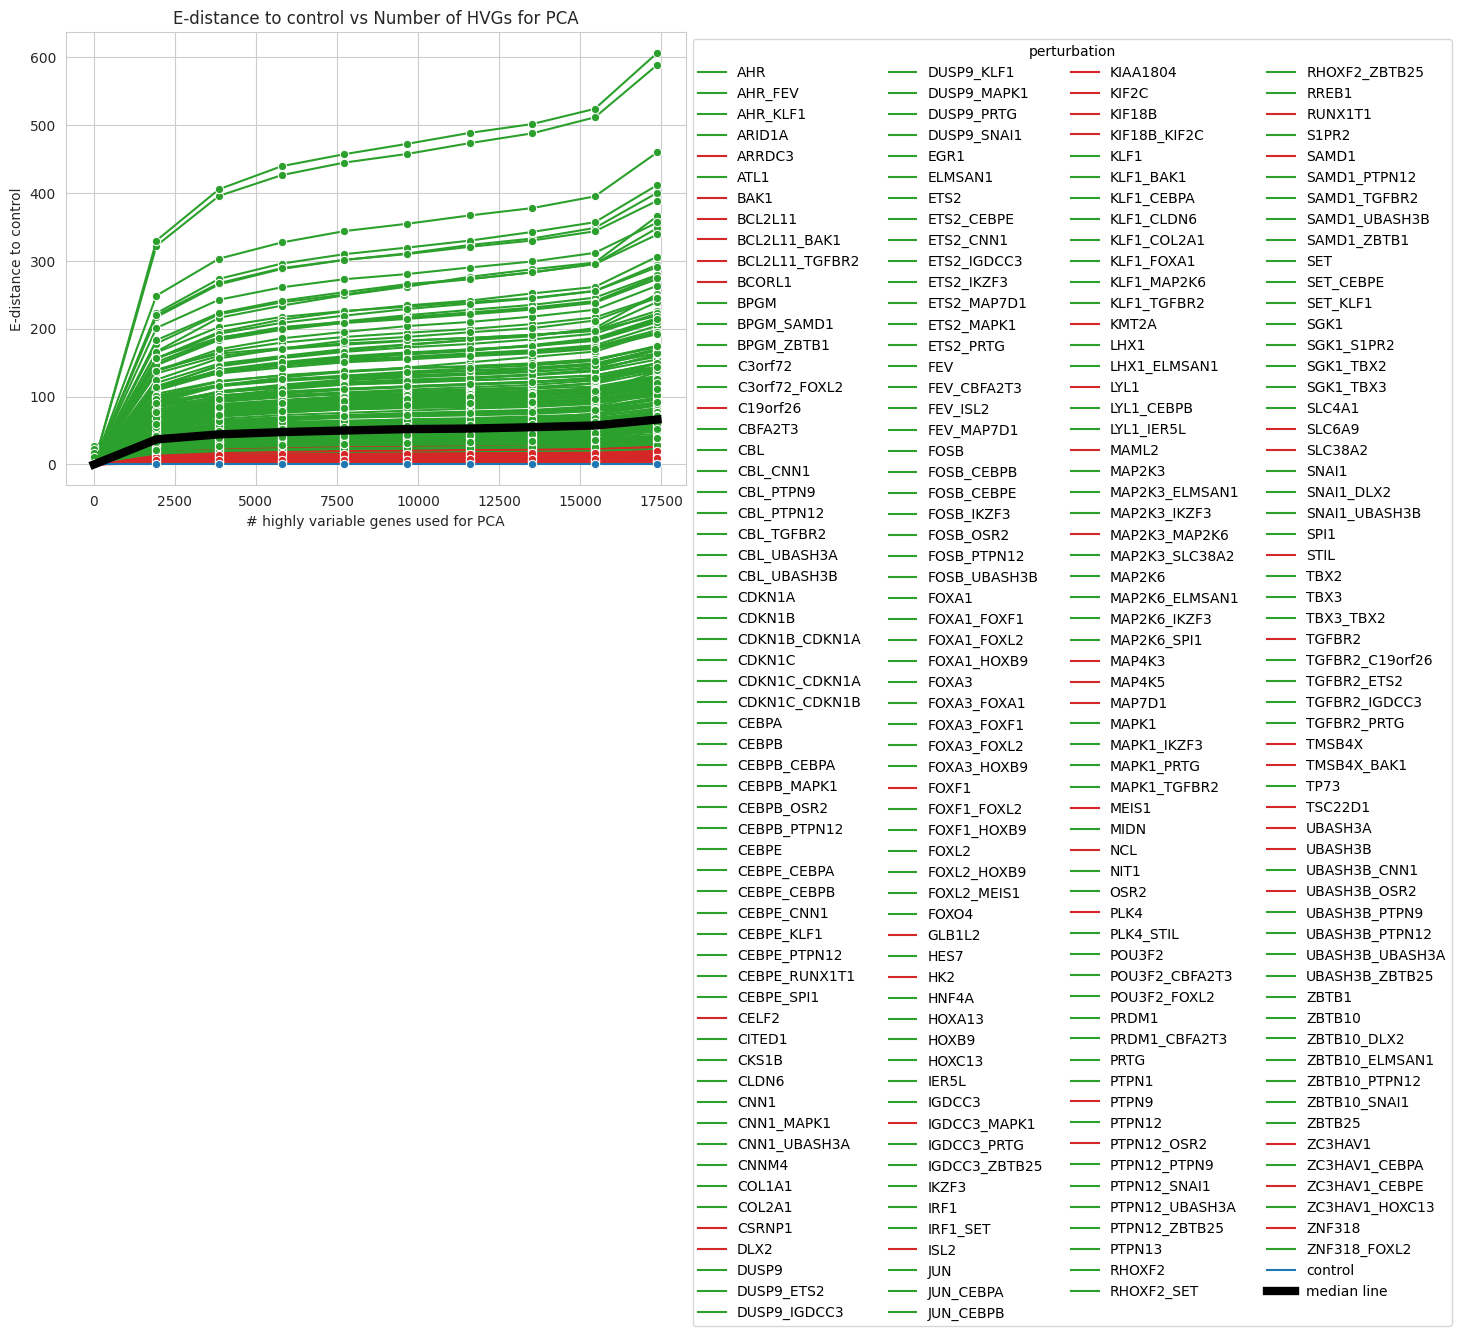

In [105]:
dataset = 'NormanWeissman2019_filtered'
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
df = test_HVGs(adata, groupby='perturbation', control='control', num=10)

# Dependence on number of PCs

In [106]:
def test_nPCs(adata, groupby='perturbation', control='control', ns=[100, 50, 30, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1], show=True):
    n_max = np.max(ns)
    sc.pp.pca(adata, use_highly_variable=False, n_comps=n_max)
    eds = []
    for n in tqdm(ns):
        adata.obsm['X_pca_sub'] = adata.obsm['X_pca'][:, :int(n)]  # subset PCA to use only n first PCs
        ed = edist_to_control(adata, groupby, control, verbose=False, obsm_key='X_pca_sub')
        eds.append(ed)
    df = pd.concat(eds, axis=1).T
    df.index = np.array(ns, dtype=int)
    df.head()
    
    path = Path(f'../snakemake/tables/etest_{dataset}_tables.csv')
    if path.exists():
        et = pd.read_csv(path, index_col=0)
        palette={g: 'tab:blue' if g==control else 'tab:green' if et.loc[g, 'significant_adj'] else 'tab:red' for g in df.columns}
    else:
        palette=None
    
    with sns.axes_style('whitegrid'):
        fig, ax = pl.subplots(1, 1, figsize=(8,6), dpi=100)
    plot=sns.lineplot(data=df.stack().reset_index(), x='level_0', y=0, hue=groupby, ax=ax, marker="o", palette=palette)
    ax.set_ylabel(f'E-distance to {control}')
    ax.set_xlabel('#PCs used')
    ax.set_xscale('log')
    ax.set_title(f'E-distance to {control} vs Number of PCs used from PCA')
    med_df=df.median(1)
    ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

    h,l = plot.axes.get_legend_handles_labels()
    plot.axes.legend_.remove()
    ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

    if show: pl.show()
    return df

100%|██████████| 13/13 [00:11<00:00,  1.16it/s]


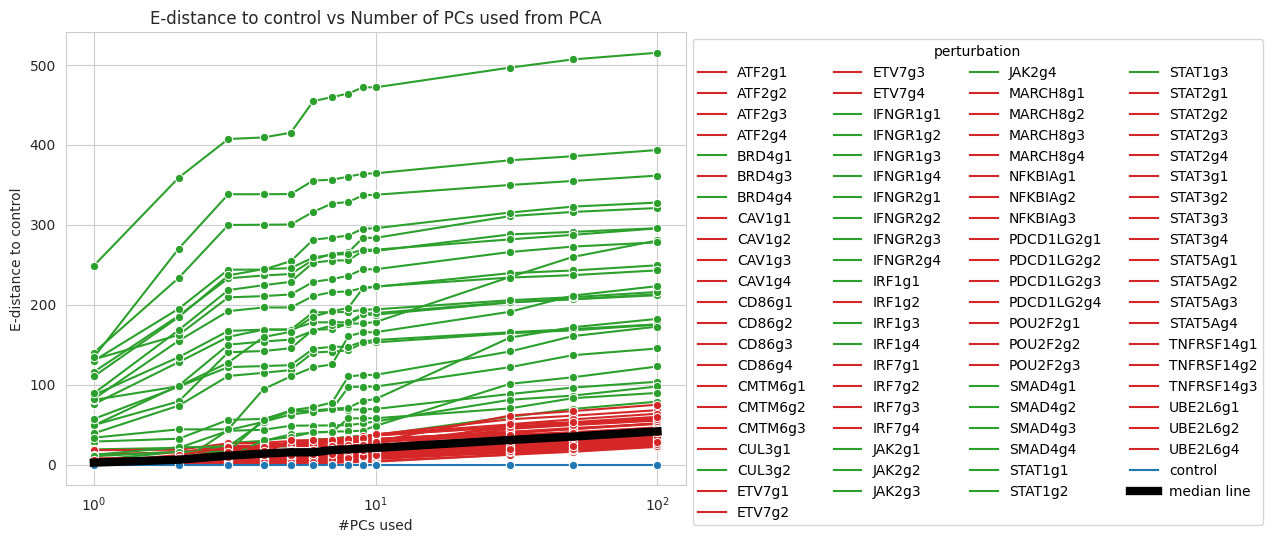

In [107]:
dataset = 'PapalexiSatija2021_eccite_RNA'
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
df = test_nPCs(adata, groupby='perturbation', control='control', ns=[100, 50, 30, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1])

100%|██████████| 13/13 [00:18<00:00,  1.43s/it]


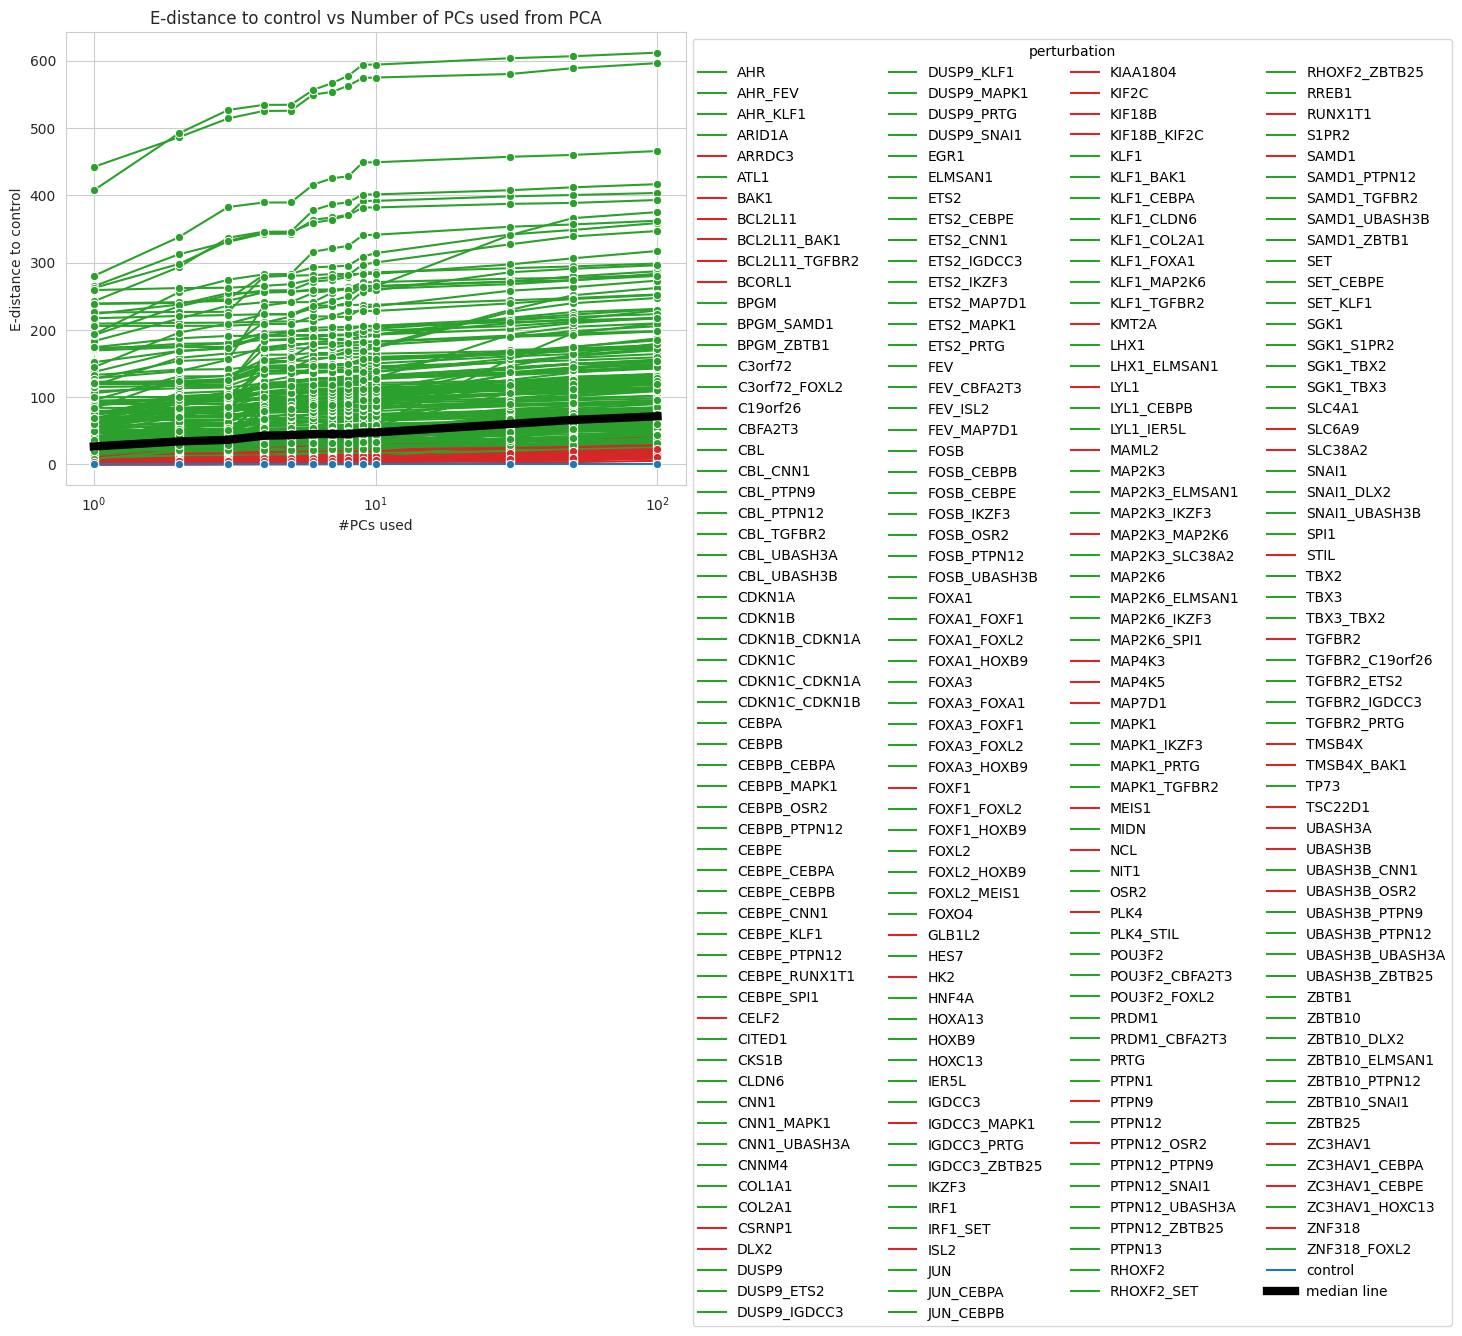

In [108]:
dataset = 'NormanWeissman2019_filtered'
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
df = test_nPCs(adata, groupby='perturbation', control='control', ns=[100, 50, 30, 10, 9, 8, 7, 6, 5, 4, 3, 2, 1])

# Dependence on number of cells

In [123]:
adata = sc.read(h5_files[f'tmp_data_{dataset}'])

In [124]:
eds = []
sigs = []
deltas = []
ncells = []
ns = np.linspace(0.05, 1, num=10)
for n in tqdm(ns):
    tdata = sc.pp.subsample(adata, fraction=n, copy=True)
    sc.pp.pca(tdata, use_highly_variable=False)
    ncells.append(tdata.obs[groupby].value_counts())
    
    # EDITST
    deltas_to_c = onesided_pca_distances(tdata, obs_key=groupby, control=control, verbose=False)
    sigmas = self_pca_distances(tdata, groupby, verbose=False)
    # derive basic statistics
    ed = 2 * deltas_to_c - sigmas - sigmas.loc[control]
    eds.append(ed)
    sigs.append(sigmas)
    deltas.append(deltas_to_c)

100%|██████████| 10/10 [01:45<00:00, 10.58s/it]


In [125]:
df = pd.concat(eds, axis=1).T
df.index = np.array(ns)
df.head()

perturbation       ETV7g4      STAT1g2  PDCD1LG2g1    IFNGR2g1       BRD4g4  \
0.050000      1948.632944  2247.299677  149.452022  955.510272  2011.133594   
0.155556      -199.862934  -564.264536 -824.308189 -374.792057  -721.220775   
0.261111      -495.312575  -297.428599 -391.156559  -64.838378  -393.606341   
0.366667      -195.303341   101.411251 -505.275431  -80.365022   -70.029624   
0.472222       -95.641060   -44.663715 -393.816440 -160.673169  -182.799944   

perturbation     STAT5Ag3      CAV1g3       JAK2g4       JAK2g1     IFNGR1g3  \
0.050000      2712.112961  481.197630  7599.386465  1463.987325  2053.701011   
0.155556      -620.316448 -947.929327   317.502550  -484.916904  -381.815171   
0.261111      -590.498705 -627.777957   107.787726  -656.891698   114.947691   
0.366667      -223.758343 -432.705319  -118.108149  -316.890752    68.934577   
0.472222      -218.107297 -326.876097   -25.215957  -167.485257   -44.934992   

perturbation  ...      CD86g1      ETV7g2    NFKBIAg1   PDCD1LG2g4  \
0.050000      ... -712.118768 -505.216810 -466.543348   613.230103   
0.155556      ... -704.347579 -759.814388 -857.095369 -1156.274482   
0.261111      ... -113.271793 -652.177967 -673.540177  -739.143698   
0.366667      ... -246.389888 -250.473272 -164.555049  -419.766746   
0.472222      ...  -33.907507 -190.122480 -239.906015  -363.527742   

perturbation       IRF7g2      IRF1g2    STAT5Ag1     UBE2L6g2    IFNGR2g2  \
0.050000              NaN         NaN         NaN          NaN         NaN   
0.155556     -1140.475495 -327.796155 -852.418195 -1061.027105 -960.229984   
0.261111      -902.925669 -391.020243 -809.582178  -793.876913 -218.827958   
0.366667      -512.627821 -156.137937 -611.427494  -712.833690 -211.752833   
0.472222      -368.863106 -254.297268 -539.681310  -529.979273   33.100196   

perturbation     NFKBIAg2  
0.050000              NaN  
0.155556     -1131.836085  
0.261111     -1053.864529  
0.366667      -633.311379  
0.472222      -273.384340  

[5 rows x 84 columns]

In [136]:
df_d = pd.concat(deltas, axis=1).T
df_d.index = np.array(ns, dtype=float)
df_s = pd.concat(sigs, axis=1).T
df_s.index = np.array(ns, dtype=float)

In [137]:
path = Path(f'../snakemake/tables/etest_{dataset}_tables.csv')
if path.exists():
    et = pd.read_csv(path, index_col=0)
    palette={g: 'tab:blue' if g==control else 'tab:green' if et.loc[g, 'significant_adj'] else 'tab:red' for g in df.columns}
else:
    palette=None

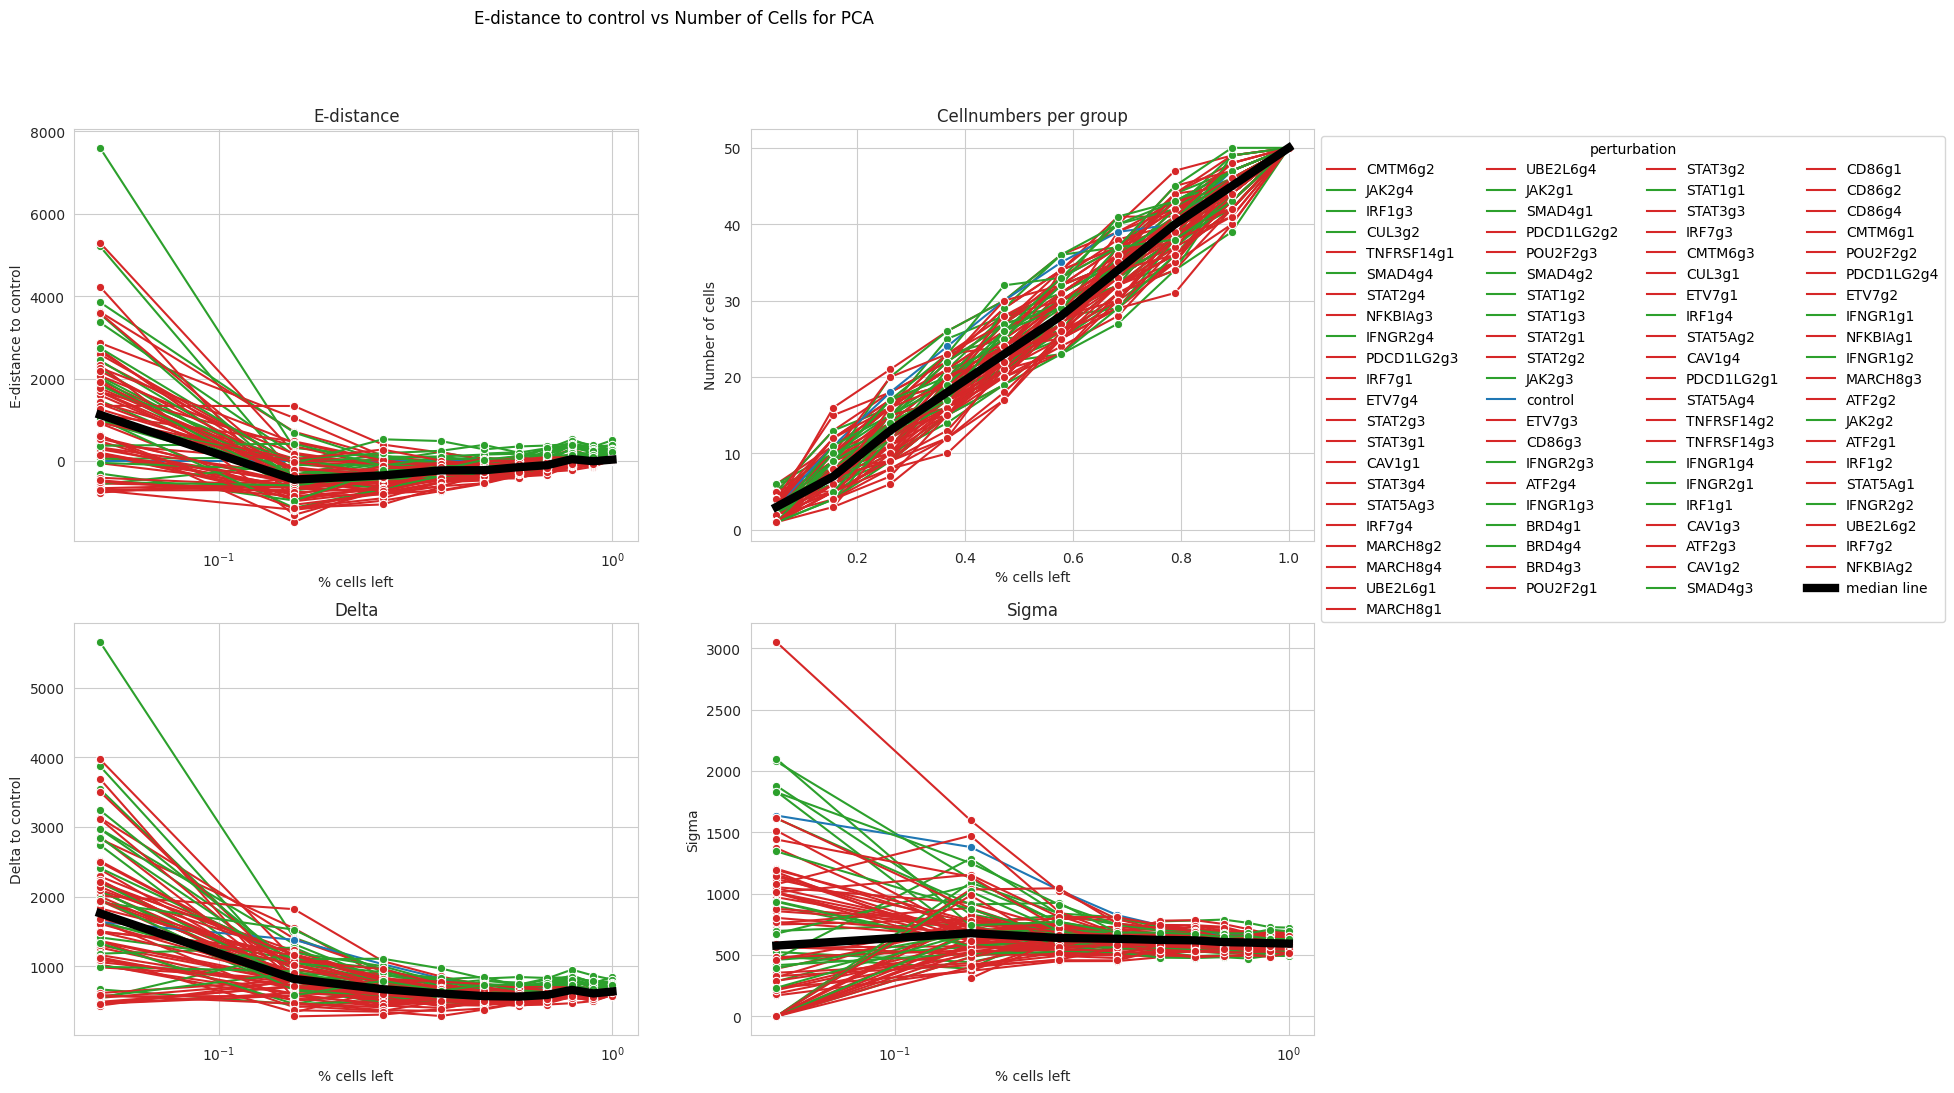

In [140]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 2, figsize=(8*2,6*2), dpi=100)
lineplot_kwargs = dict(x='level_0', y=0, marker="o", palette=palette)
ax=axs[0,0]
sns.lineplot(data=df.stack().reset_index(), hue=groupby, ax=ax, legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('% cells left')
ax.set_title('E-distance')
ax.set_xscale('log')
med_df=df.median(1)
ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

ax=axs[0,1]
ndf = pd.DataFrame(ncells, index=ns)
plot=sns.lineplot(data=ndf.stack().reset_index(), hue='level_1', ax=ax, legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel('Number of cells')
ax.set_xlabel('% cells left')
ax.set_title('Cellnumbers per group')
med_ndf=ndf.median(1)
ax.plot(med_ndf.index, med_ndf.values, label='median line', linewidth=6, color='black')
h,l = plot.axes.get_legend_handles_labels()
plot.axes.legend_.remove()
ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

ax=axs[1,0]
plot=sns.lineplot(data=df_d.stack().reset_index(), hue=groupby, ax=ax, legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel(f'Delta to {control}')
ax.set_xlabel('% cells left')
ax.set_title('Delta')
ax.set_xscale('log')
med_df=df_d.median(1)
ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

ax=axs[1,1]
plot=sns.lineplot(data=df_s.stack().reset_index(), hue=groupby, ax=ax, legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel(f'Sigma')
ax.set_xlabel('% cells left')
ax.set_title('Sigma')
ax.set_xscale('log')
med_df=df_s.median(1)
ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

pl.suptitle(f'E-distance to {control} vs Number of Cells for PCA')

pl.show()

# Dependence on counts

In [111]:
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
adata.X = adata.layers['counts'].copy()  # reset

In [112]:
eds = []
sigs = []
deltas = []
ncounts = []
ns = np.linspace(0.01, 1, num=10)
total_counts = np.sum(adata.X>0)
for n in tqdm(ns):
    tdata = sc.pp.downsample_counts(adata, total_counts=int(n*total_counts), copy=True)
    tdata.obs['ncounts'] = tdata.X.sum(1)
    ncounts.append(tdata.obs.groupby(groupby).mean()['ncounts'])
    sc.pp.normalize_per_cell(tdata)
    sc.pp.log1p(tdata)
    sc.pp.highly_variable_genes(tdata, n_top_genes=2000)
    sc.pp.pca(tdata, use_highly_variable=False)
    # EDITST
    deltas_to_c = onesided_pca_distances(tdata, obs_key=groupby, control=control, verbose=False)
    sigmas = self_pca_distances(tdata, groupby, verbose=False)
    # derive basic statistics
    ed = 2 * deltas_to_c - sigmas - sigmas.loc[control]
    eds.append(ed)
    sigs.append(sigmas)
    deltas.append(deltas_to_c)

  0%|          | 0/10 [00:00<?, ?it/s]


100%|██████████| 84/84 [00:00<00:00, 172.72it/s]

 10%|█         | 1/10 [00:04<00:42,  4.72s/it]


100%|██████████| 84/84 [00:00<00:00, 172.86it/s]

 20%|██        | 2/10 [00:09<00:39,  4.88s/it]


100%|██████████| 84/84 [00:00<00:00, 172.61it/s]

 30%|███       | 3/10 [00:15<00:37,  5.34s/it]


100%|██████████| 84/84 [00:00<00:00, 171.20it/s]

 40%|████      | 4/10 [00:22<00:35,  5.97s/it]


100%|██████████| 84/84 [00:00<00:00, 173.03it/s]

 50%|█████     | 5/10 [00:29<00:32,  6.44s/it]


100%|██████████| 84/84 [00:00<00:00, 174.31it/s]

 60%|██████    | 6/10 [00:38<00:28,  7.10s/it]


100%|██████████| 84/84 [00:00<00:00, 173.53it/s]

 70%|███████   | 7/10 [00:46<00:22,  7.53s/it]


100%|██████████| 84/84 [00:00<00:00, 172.88it/s]

 80%|████████  | 8/10 [00:55<00:15,  7.97s/it]


100%|██████████| 84/84 [00:00<00:00, 174.26it/s]

 90%|█████████ | 9/10 [01:09<00:09,  9.85s/it]


100%|██████████| 84/84 [00:00<00:00, 175.82it/s]

100%|██████████| 10/10 [01:24<00:00,  8.49s/it]


In [113]:
df = pd.concat(eds, axis=1).T
df.index = np.array(ns, dtype=float)
df.head()

perturbation  control   IFNGR2g1    ATF2g1   IFNGR1g3    CD86g1   IFNGR2g2  \
0.01              0.0   0.319172  0.198471   0.288894  0.201838   0.230982   
0.12              0.0   9.828577  1.716831  11.340814  1.725269   6.560553   
0.23              0.0  21.119646  2.942397  23.028943  2.561357  14.078934   
0.34              0.0  33.690589  4.704870  34.755477  3.682686  21.202972   
0.45              0.0  45.742732  6.185916  46.747552  4.393709  28.604088   

perturbation  POU2F2g1     JAK2g2   IFNGR1g2  TNFRSF14g1  ...     IRF7g3  \
0.01          0.260226   0.282289   0.293730    0.233680  ...   0.257015   
0.12          1.650605   8.639670   8.388878    1.372517  ...   4.450286   
0.23          2.847743  18.291887  16.786363    2.720291  ...   8.451406   
0.34          3.058355  27.340289  26.037729    3.105603  ...  11.506403   
0.45          3.469734  36.031301  33.687311    4.076638  ...  16.312604   

perturbation     ATF2g3  PDCD1LG2g2    STAT3g4    STAT3g2    STAT2g4  \
0.01           0.367996    0.411385   0.295748   0.401582   0.353752   
0.12           4.259325    3.324403   3.942302   3.896329   5.347718   
0.23           7.650232    6.758108   9.531454   7.846639  10.391058   
0.34          11.763149   11.189138  13.970534  12.023636  15.791367   
0.45          16.543898   15.524232  19.700253  17.222262  20.674422   

perturbation     BRD4g1    SMAD4g3     IRF7g4    STAT1g1  
0.01           1.558667   0.383574   0.271987   0.432969  
0.12          10.584790   8.356670   4.032408  19.396416  
0.23          20.067249  17.005115   7.902484  37.824327  
0.34          31.500167  25.930415  11.438998  56.115464  
0.45          43.031849  36.696359  14.234544  74.118382  

[5 rows x 84 columns]

In [121]:
df_d = pd.concat(deltas, axis=1).T
df_d.index = np.array(ns, dtype=float)
df_s = pd.concat(sigs, axis=1).T
df_s.index = np.array(ns, dtype=float)

In [80]:
path = Path(f'../snakemake/tables/etest_{dataset}_tables.csv')
if path.exists():
    et = pd.read_csv(path, index_col=0)
    palette={g: 'tab:blue' if g==control else 'tab:green' if et.loc[g, 'significant_adj'] else 'tab:red' for g in df.columns}
else:
    palette=None

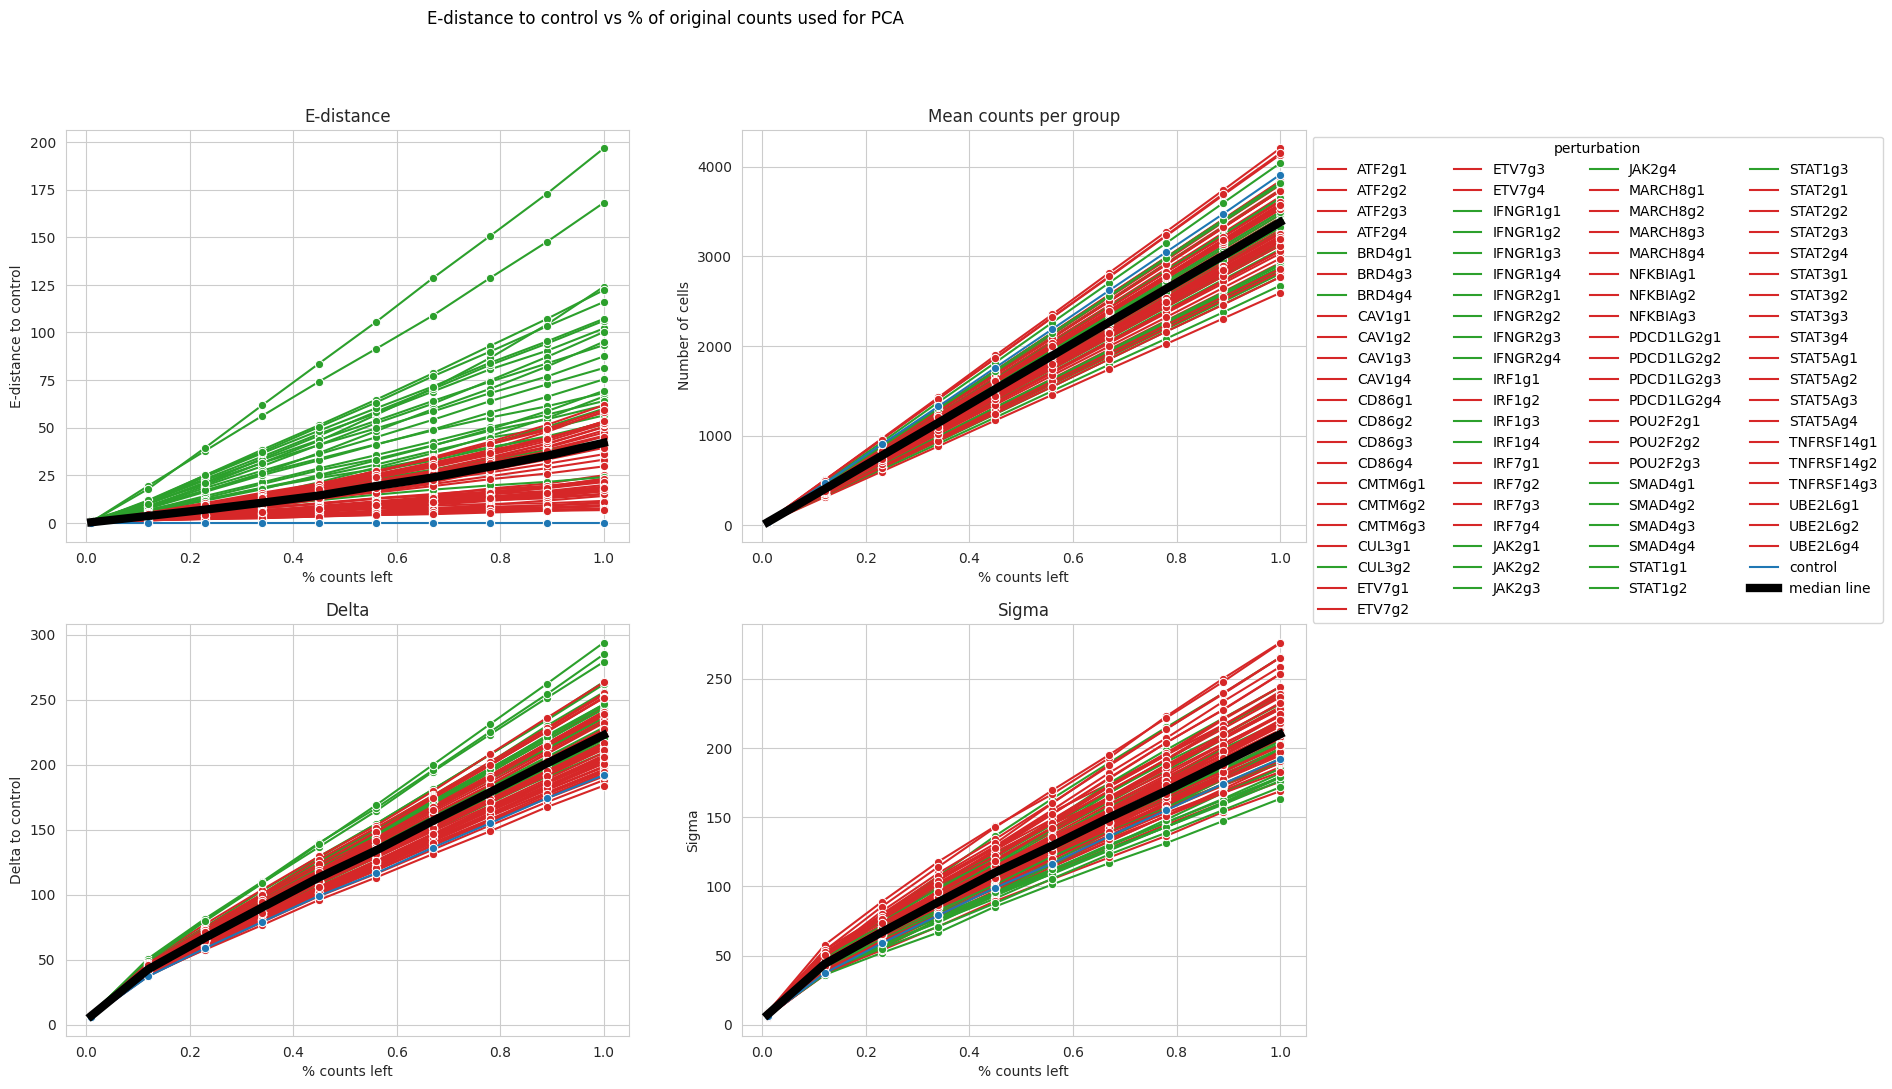

In [120]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 2, figsize=(8*2,6*2), dpi=100)
lineplot_kwargs = dict(x='level_0', y=0, hue=groupby, marker="o", palette=palette)
ax=axs[0,0]
plot=sns.lineplot(data=df.stack().reset_index(), ax=ax, legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('% counts left')
ax.set_title('E-distance')
med_df=df.median(1)
ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

ax=axs[0,1]
ndf = pd.DataFrame(ncounts, index=ns)
plot=sns.lineplot(data=ndf.stack().reset_index(), ax=ax, legend=ax==axs[0,1], **lineplot_kwargs)
ax.set_ylabel('Number of cells')
ax.set_xlabel('% counts left')
ax.set_title('Mean counts per group')
med_ndf=ndf.median(1)
ax.plot(med_ndf.index, med_ndf.values, label='median line', linewidth=6, color='black')
h,l = plot.axes.get_legend_handles_labels()
plot.axes.legend_.remove()
ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

ax=axs[1,0]
plot=sns.lineplot(data=df_d.stack().reset_index(), ax=ax, legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel(f'Delta to {control}')
ax.set_xlabel('% counts left')
ax.set_title('Delta')
med_df=df_d.median(1)
ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

ax=axs[1,1]
plot=sns.lineplot(data=df_s.stack().reset_index(), ax=ax, legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel(f'Sigma')
ax.set_xlabel('% counts left')
ax.set_title('Sigma')
med_df=df_s.median(1)
ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

pl.suptitle(f'E-distance to {control} vs % of original counts used for PCA')

pl.show()

# Dependence on counts (with testing)

In [185]:
adata = sc.read(h5_files[f'tmp_data_{dataset}'])
adata.X = adata.layers['counts'].copy()  # reset

In [186]:
sigs = {}
deltas = {}
tests = {}
ncounts = {}
ns = np.linspace(0.01, 1, num=5)
total_counts = np.sum(adata.X>0)
for n in tqdm(ns):
    tdata = sc.pp.downsample_counts(adata, total_counts=int(n*total_counts), copy=True)
    tdata.obs['ncounts'] = tdata.X.sum(1)
    ncounts[n] = tdata.obs.groupby(groupby).mean()['ncounts']
    sc.pp.normalize_per_cell(tdata)
    sc.pp.log1p(tdata)
    sc.pp.highly_variable_genes(tdata, n_top_genes=2000)
    sc.pp.pca(tdata, use_highly_variable=False)
    # STATS
    deltas[n] = onesided_pca_distances(tdata, obs_key=groupby, control=control, verbose=False)
    sigs[n] = self_pca_distances(tdata, groupby, verbose=False)
    # derive basic statistics
    # ed = 2 * deltas_to_c - sigmas - sigmas.loc[control]
    # test
    tests[n] = etest(tdata, groupby, control='control', runs=10)

  0%|          | 0/5 [00:00<?, ?it/s]


 20%|██        | 1/5 [01:22<05:29, 82.30s/it]


 40%|████      | 2/5 [02:49<04:15, 85.33s/it]


 60%|██████    | 3/5 [04:19<02:54, 87.31s/it]


 80%|████████  | 4/5 [05:52<01:29, 89.64s/it]


100%|██████████| 5/5 [07:26<00:00, 89.36s/it]


In [211]:
sdf = pd.concat([
    pd.concat(tests),
    pd.concat(deltas),
    pd.concat(sigs),
    pd.concat(ncounts)
], axis=1).reset_index()
sdf.columns = ['n', groupby, 'edist', 'pvalue', 'significant', 'pvalue_adj', 'significant_adj', 'delta', 'sigma', 'ncounts']
sdf['significant_adj'][sdf[groupby]==control]='control'
# annotate newly insignificant
sdf['significant_adj_new'] = sdf['significant_adj']
for g in sdf.perturbation.unique():
    if sdf['significant_adj'][(sdf[groupby]==g) & (sdf['n']==1)].iloc[0]==True:
        sdf['significant_adj_new'][(sdf[groupby]==g) & (sdf['significant_adj']==False)] = 'False (lost)'
    elif sdf['significant_adj'][(sdf[groupby]==g) & (sdf['n']==1)].iloc[0]==False:
        sdf['significant_adj_new'][(sdf.perturbation==g) & (sdf['significant_adj']==True)] = 'True (gained)'
sdf

n perturbation      edist  pvalue  significant  pvalue_adj  \
0    0.01       ATF2g1   0.198471     0.5        False       1.000   
1    0.01       ATF2g2   0.245369     0.8        False       1.000   
2    0.01       ATF2g3   0.367996     0.0         True       0.000   
3    0.01       ATF2g4   0.191184     0.8        False       1.000   
4    0.01       BRD4g1   1.558667     0.0         True       0.000   
..    ...          ...        ...     ...          ...         ...   
415  1.00   TNFRSF14g3   6.678337     0.6        False       0.936   
416  1.00     UBE2L6g1  18.509410     0.0         True       0.000   
417  1.00     UBE2L6g2  52.466633     0.0         True       0.000   
418  1.00     UBE2L6g4  53.221576     0.0         True       0.000   
419  1.00      control   0.000000     0.0         True       0.000   

    significant_adj       delta       sigma      ncounts significant_adj_new  
0             False    6.029760    5.886920    42.900002               False  
1             False    7.202469    8.185441    28.840000        False (lost)  
2              True    7.431485    8.520846    32.299999                True  
3             False    6.323746    6.482179    37.220001               False  
4              True    8.551710    9.570625    26.580000                True  
..              ...         ...         ...          ...                 ...  
415           False  194.633364  190.697207  3556.540039               False  
416            True  206.171549  201.942504  3567.479980                True  
417            True  227.142359  209.926901  3118.979980                True  
418            True  238.633635  232.154510  3193.780029                True  
419         control  191.891184  191.891184  3909.840088             control  

[420 rows x 11 columns]

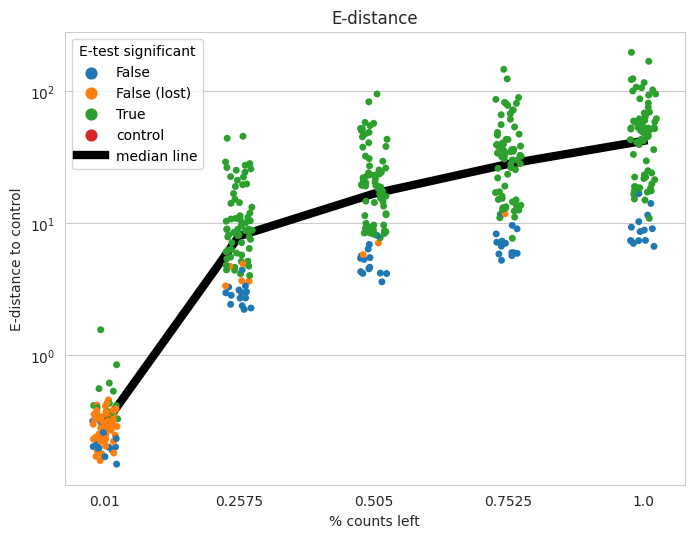

In [226]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8,6), dpi=100)
ax.set_yscale('log')
sns.stripplot(data=sdf, x='n', y='edist', hue='significant_adj_new')
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('% counts left')
ax.set_title('E-distance')
med_df=sdf.groupby('n').median()
ax.plot(np.arange(len(med_df)), med_df.edist, label='median line', linewidth=6, color='black')
ax.legend(title='E-test significant')
pl.show()

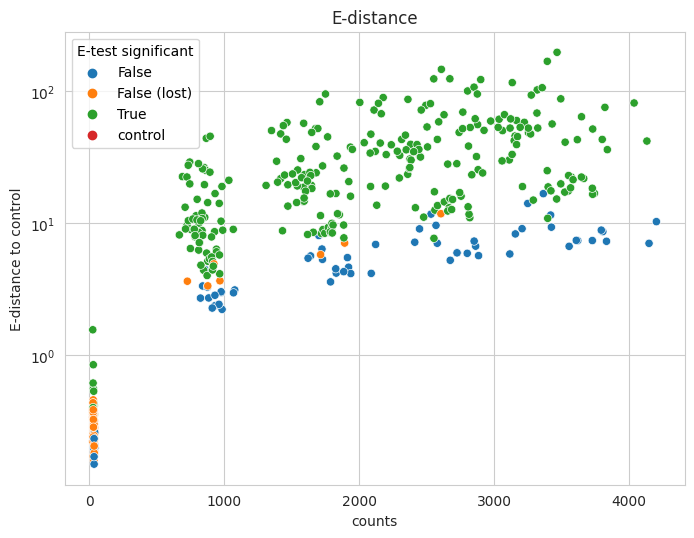

In [231]:
with sns.axes_style('whitegrid'):
    fig, ax = pl.subplots(figsize=(8,6), dpi=100)
ax.set_yscale('log')
sns.scatterplot(data=sdf, x='ncounts', y='edist', hue='significant_adj_new')
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('counts')
ax.set_title('E-distance')
#med_df=sdf.groupby('ncounts').median()
#ax.plot(med_df.index, med_df.edist, label='median line', linewidth=6, color='black')
ax.legend(title='E-test significant')
pl.show()

In [222]:
med_df

edist  pvalue  significant  pvalue_adj       delta       sigma  \
n                                                                            
0.0100   0.297963     0.3          0.0         1.0    6.775431    7.324270   
0.2575   7.972731     0.0          1.0         0.0   72.941992   72.690175   
0.5050  16.723155     0.0          1.0         0.0  123.354270  119.763058   
0.7525  28.103507     0.0          1.0         0.0  173.823314  164.402881   
1.0000  41.995934     0.0          1.0         0.0  222.733718  209.795788   

            ncounts  
n                    
0.0100    33.489998  
0.2575   866.340027  
0.5050  1705.170044  
0.7525  2543.370117  
1.0000  3379.799805

In [176]:
path = Path(f'../snakemake/tables/etest_{dataset}_tables.csv')
if path.exists():
    et = pd.read_csv(path, index_col=0)
    palette={g: 'tab:blue' if g==control else 'tab:green' if et.loc[g, 'significant_adj'] else 'tab:red' for g in df.columns}
else:
    palette=None

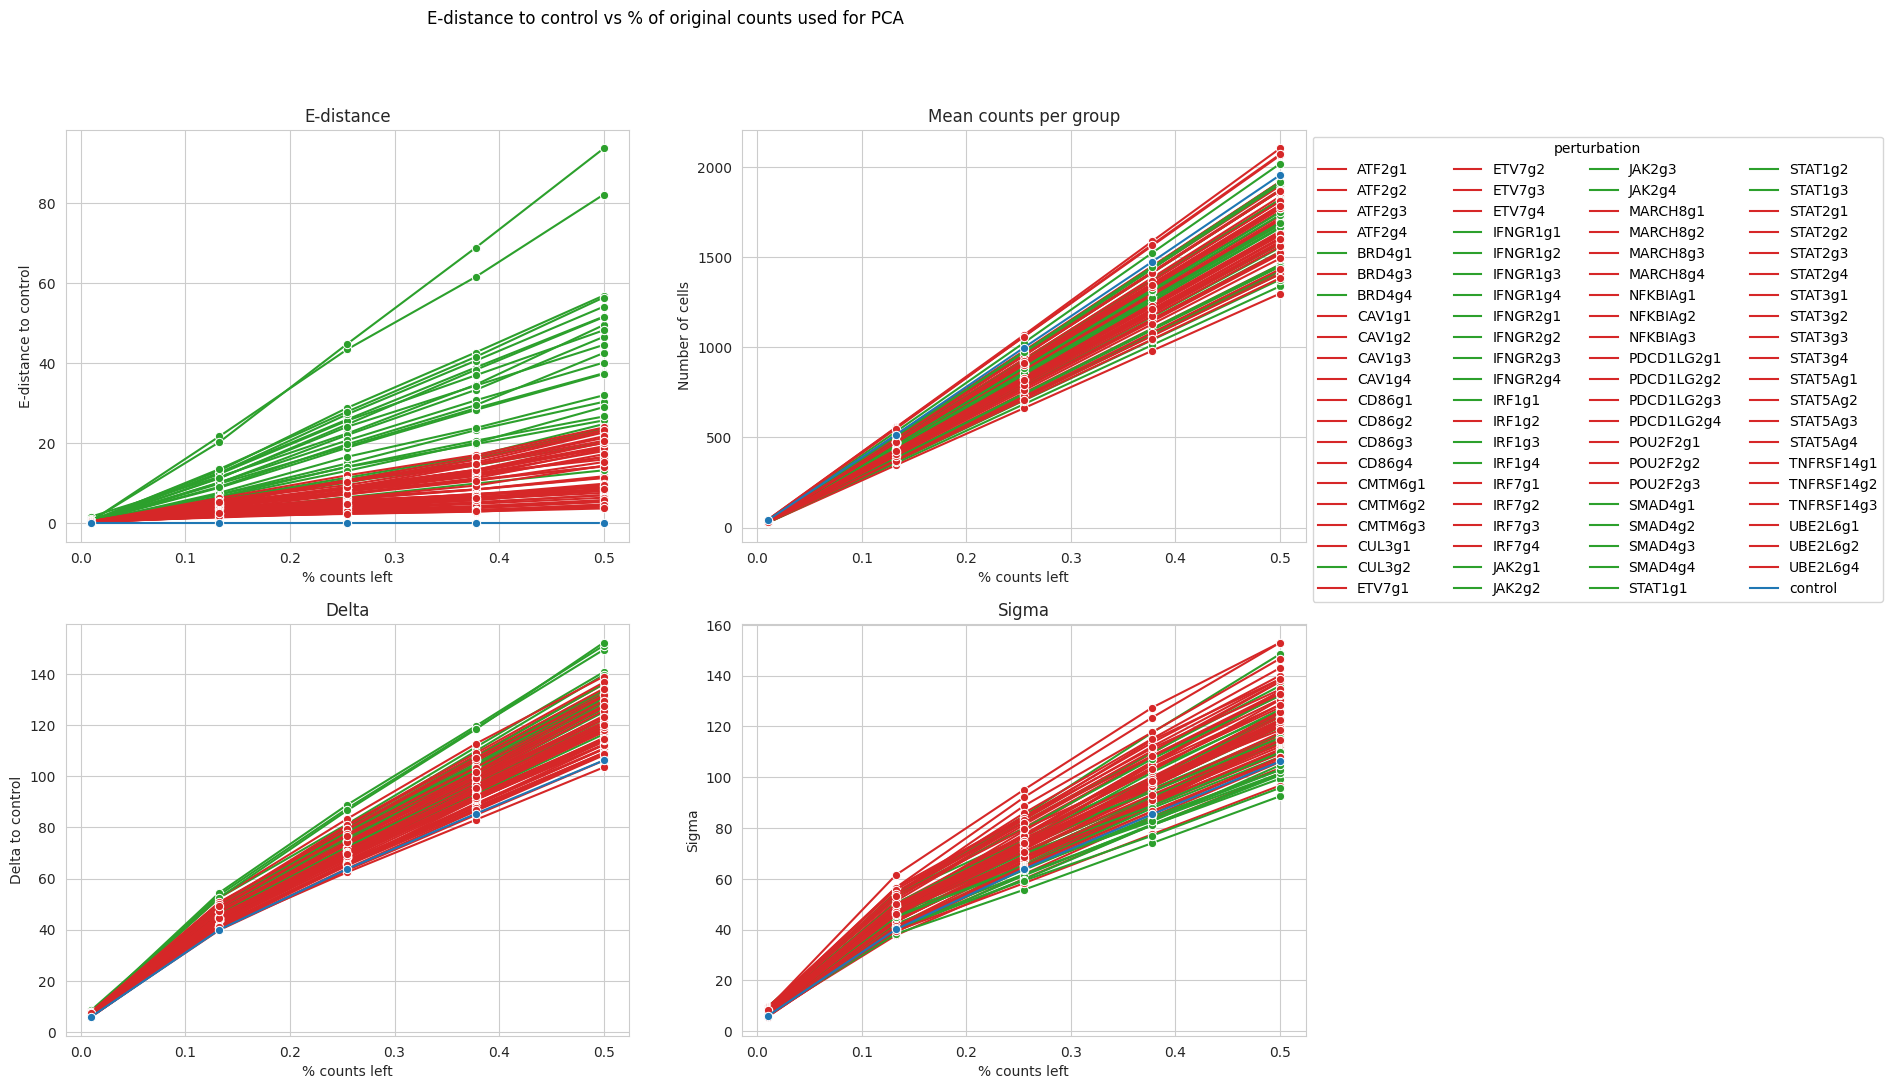

In [177]:
with sns.axes_style('whitegrid'):
    fig, axs = pl.subplots(2, 2, figsize=(8*2,6*2), dpi=100)
lineplot_kwargs = dict(hue=groupby, marker="o", palette=palette)
ax=axs[0,0]
plot=sns.lineplot(data=sdf, ax=ax, x='n', y='edist', legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel(f'E-distance to {control}')
ax.set_xlabel('% counts left')
ax.set_title('E-distance')
# med_df=sdf.median(1)
# ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

ax=axs[0,1]
plot=sns.lineplot(data=sdf, ax=ax, x='n', y='ncounts', legend=ax==axs[0,1], **lineplot_kwargs)
ax.set_ylabel('Number of cells')
ax.set_xlabel('% counts left')
ax.set_title('Mean counts per group')
#med_ndf=ndf.median(1)
#ax.plot(med_ndf.index, med_ndf.values, label='median line', linewidth=6, color='black')
h,l = plot.axes.get_legend_handles_labels()
plot.axes.legend_.remove()
ax.legend(h,l, ncol=4, bbox_to_anchor=(1,1), title=groupby)

ax=axs[1,0]
plot=sns.lineplot(data=sdf, ax=ax, x='n', y='delta', legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel(f'Delta to {control}')
ax.set_xlabel('% counts left')
ax.set_title('Delta')
#med_df=df_d.median(1)
#ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

ax=axs[1,1]
plot=sns.lineplot(data=sdf, ax=ax, x='n', y='sigma', legend=ax==axs[0,-1], **lineplot_kwargs)
ax.set_ylabel(f'Sigma')
ax.set_xlabel('% counts left')
ax.set_title('Sigma')
#med_df=df_s.median(1)
#ax.plot(med_df.index, med_df.values, label='median line', linewidth=6, color='black')

pl.suptitle(f'E-distance to {control} vs % of original counts used for PCA')

pl.show()